# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ

*Подготовила Овсиенко Олеся, группа 317*

Структура:
- Validation, Validationannot - изображения и маски из валидационного сета в формате Camvid 1.0
- Train, Trainannot - соответственно из трейн сета

Доп файлы:
- label_colors.txt - цвета классов масок сегментаций из трейн и тест сета в формате Camvid 1.0

In [1]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

In [3]:
import os

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [4]:
!unzip camvid-dataset.zip

Archive:  camvid-dataset.zip
   creating: camvid-dataset/
  inflating: __MACOSX/._camvid-dataset  
  inflating: camvid-dataset/.DS_Store  
  inflating: __MACOSX/camvid-dataset/._.DS_Store  
  inflating: camvid-dataset/Train.txt  
  inflating: __MACOSX/camvid-dataset/._Train.txt  
  inflating: camvid-dataset/Validation.txt  
  inflating: __MACOSX/camvid-dataset/._Validation.txt  
   creating: camvid-dataset/Trainannot/
  inflating: __MACOSX/camvid-dataset/._Trainannot  
  inflating: camvid-dataset/label_colors.txt  
  inflating: __MACOSX/camvid-dataset/._label_colors.txt  
   creating: camvid-dataset/Train/
   creating: camvid-dataset/Validationannot/
  inflating: __MACOSX/camvid-dataset/._Validationannot  
   creating: camvid-dataset/Validation/
  inflating: camvid-dataset/Trainannot/01.png  
  inflating: __MACOSX/camvid-dataset/Trainannot/._01.png  
  inflating: camvid-dataset/Trainannot/15.png  
  inflating: __MACOSX/camvid-dataset/Trainannot/._15.png  
  inflating: camvid-dataset/Tr

In [5]:
DATSET_NAME = "camvid-dataset"

X_TRAIN_DIR = f"{DATSET_NAME}/Train"
Y_TRAIN_DIR = f"{DATSET_NAME}/Trainannot"

X_VALID_DIR = f"{DATSET_NAME}/Validation"
Y_VALID_DIR = f"{DATSET_NAME}/Validationannot"

X_TEST_DIR = f"{DATSET_NAME}/Validation"
Y_TEST_DIR = f"{DATSET_NAME}/Validationannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

Задание констант:

In [6]:
CLASSES = [
    "background",
    "white_egg",
    "brown_egg",
]
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 70
BATCH_SIZE = 8

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Вспомогательные функции

В данном примере в датасете на входе имеется трехканальная (так как 3 класса) фотка где в кажом пикселе стоит во всех каналах 0 кроме одного в котором 1. Тем самым кодируется класс конкретного пикселя в маске

In [126]:
def create_annotations_of_no_calsses_images(images_folder, annotations_folder):
    image_files = os.listdir(images_folder)
    for image_file in image_files:
        image_path = os.path.join(images_folder, image_file)
        annotation_path = os.path.join(annotations_folder, f"{os.path.splitext(image_file)[0]}.png")
        img = Image.open(image_path)
        width, height = img.size

        if not os.path.exists(annotation_path):
            img = Image.new('RGB', (width, height), color='black')
            img.save(annotation_path)

def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """
    Преобразует многоканальную маску (C, H, W) в трехканальное изображение (H, W, 3),
    где каждый класс раскрашивается в соответствии с colors_imshow.
    Также подсчитывает количество объектов (яиц) для каждого класса.

    Параметры:
        mc_mask (np.ndarray): Многоканальная маска формы (C, H, W).

    Возвращает:
        sc_mask (np.ndarray): Трехканальное изображение формы (H, W, 3).
        object_counts (dict): Словарь с количеством объектов для каждого класса.
    """
    colors_imshow = {
        "background": np.array([0, 0, 0]),
        "white_egg": np.array([0, 255, 0]),
        "brown_egg": np.array([255, 0, 0]),
    }

    sc_mask = np.zeros((mc_mask.shape[1], mc_mask.shape[2], 3), dtype=np.uint8)
    object_counts = {}

    for i, singlechannel_mask in enumerate(mc_mask):
        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        if cls != "background":
            num_labels, labels = cv2.connectedComponents(singlechannel_mask.astype(np.uint8))
            object_counts[cls] = num_labels - 1

        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)

    return sc_mask, object_counts

def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения с информацией о количестве объектов """
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, object_counts = _convert_multichannel2singlechannel(multichennel_mask)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img)
    axes[0].set_title("\nИзображение", fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(mask_to_show)
    axes[1].set_title("\nМаска", fontsize=14)
    axes[1].axis('off')

    text_area = "Количество объектов:\n"
    for cls in CLASSES:
        if cls != "background":
            text_area += f"{cls}: {object_counts.get(cls, 0)}\n"

    plt.figtext(
        0.5, 0.01,
        text_area,
        wrap=True,
        horizontalalignment='center',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.savefig('augmentations', format='pdf')
    plt.show()


# Dataloader

Использовать если есть фотки на которых вся разметка классом background:

In [ ]:
#create_annotations_of_no_calsses_images(X_TRAIN_DIR, Y_TRAIN_DIR)
#create_annotations_of_no_calsses_images(X_VALID_DIR, Y_VALID_DIR)
#create_annotations_of_no_calsses_images(X_TEST_DIR, Y_TEST_DIR)

In [8]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = sorted(glob(f"{images_dir}/*"))
        self.masks_paths = sorted(glob(f"{masks_dir}/*"))

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

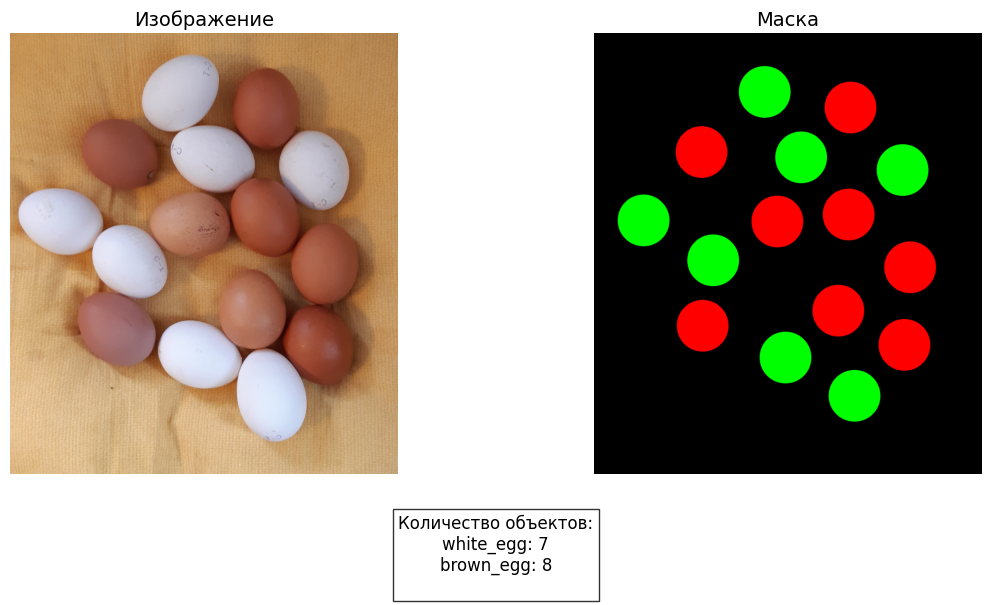

In [23]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
index = np.random.randint(len(dataset))
image, mask = dataset[index]
visualize_multichennel_mask(image, mask)

Из этого примера становится ясно, почему в качестве масок выделялась не вся область яиц, а лишь их часть (центр) : так как наша цель - посчитать количество разных яиц, то мы не хотим, чтобы одинаковые яйца "слиплялись" в один общий контур, что вызвало бы неверное вычисление.

# Augmentations

In [85]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на train:

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [138]:
augmented_dataset = Dataset(
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

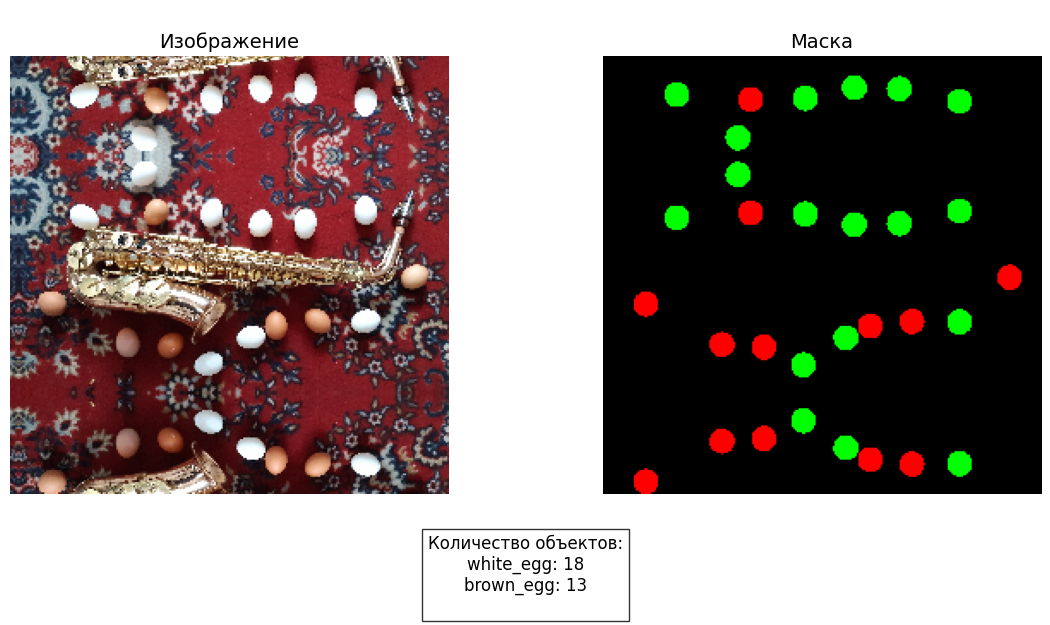

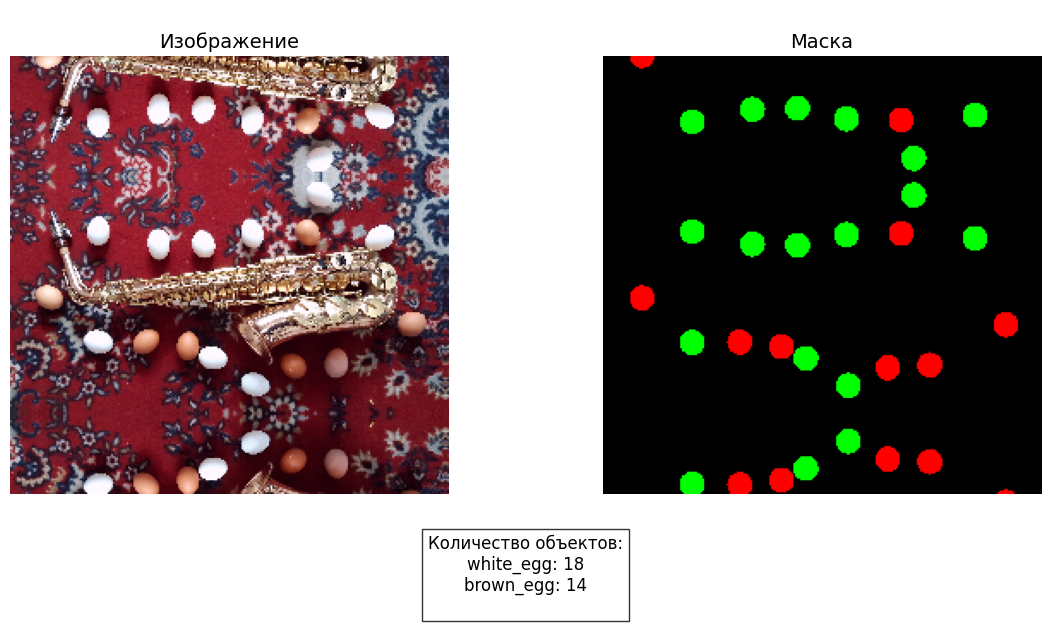

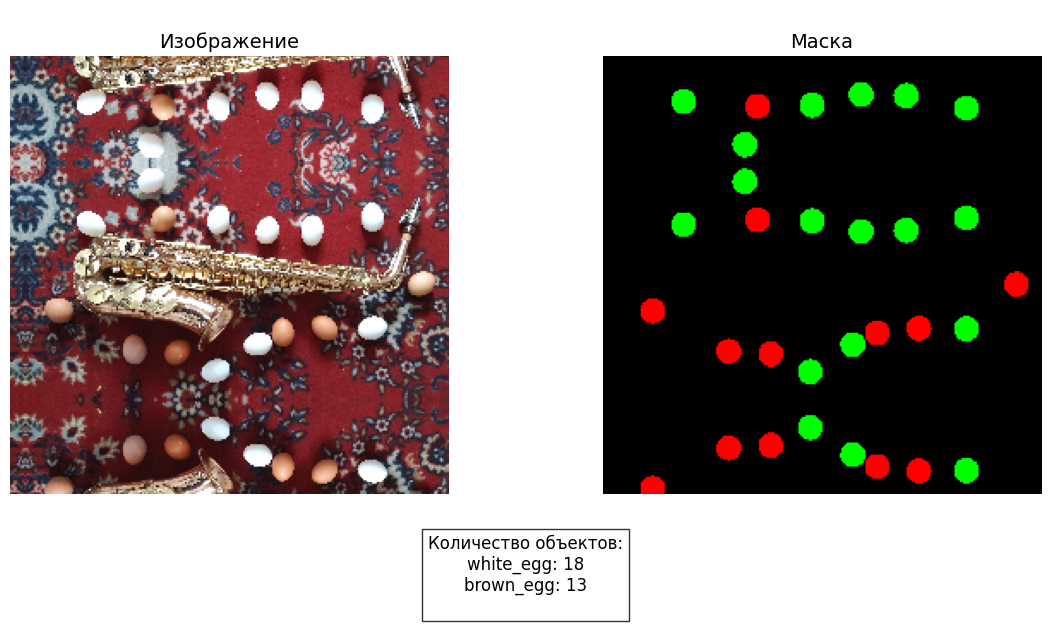

In [142]:
for i in range(3):
    image, mask = augmented_dataset[20]
    visualize_multichennel_mask(image, mask)

Пример аугментаций на val:

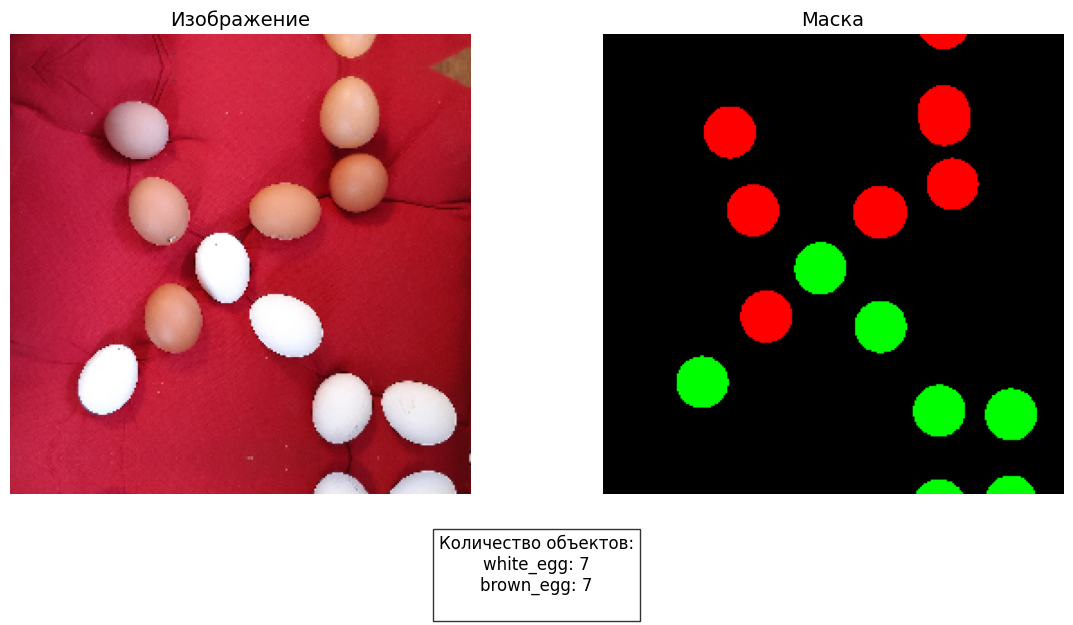

In [30]:
augmented_dataset = Dataset(
    X_VALID_DIR,
    Y_VALID_DIR,
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create model and train

In [31]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 448MB/s]


In [32]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [33]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [34]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7e61054196c0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [81]:
train_dataset = Dataset(
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR,
    Y_VALID_DIR,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [36]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=INIT_LR),
])

In [37]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Обучение:

In [38]:
import os

os.makedirs('models', exist_ok=True)

In [39]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)

    os.makedirs('models', exist_ok=True)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'models/best_model_new.pth')
        # Save the model with JIT
        # Create a tensor with the specified dimensions
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        # Trace the model using the example input
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, 'models/best_model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
valid: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s, dice_loss - 0.9065, fscore - 0.05342, iou_score - 0.02746]
Model saved!
LR: 0.0005

Epoch: 1
valid: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s, dice_loss - 0.7991, fscore - 0.08529, iou_score - 0.04463]
Model saved!
LR: 0.0005

Epoch: 2
valid: 100%|██████████| 6/6 [00:01<00:00,  5.02it/s, dice_loss - 0.6905, fscore - 0.2775, iou_score - 0.1662]
Model saved!
LR: 0.0005

Epoch: 3
valid: 100%|██████████| 6/6 [00:01<00:00,  5.06it/s, dice_loss - 0.5303, fscore - 0.5765, iou_score - 0.4142]
Model saved!
LR: 0.0005

Epoch: 4
valid: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s, dice_loss - 0.5515, fscore - 0.5564, iou_score - 0.3933]
LR: 0.0005

Epoch: 5
valid: 100%|██████████| 6/6 [00:01<00:00,  5.19it/s, dice_loss - 0.539, fscore - 0.5715, iou_score - 0.4079]
LR: 0.0005

Epoch: 6
valid: 100%|██████████| 6/6 [00:01<00:00,  5.15it/s, dice_loss - 0.4046, fscore - 0.7365, iou_score - 0.5847]
Model saved!
LR: 0.0005

Epoch: 7
valid

Оценка обучения:

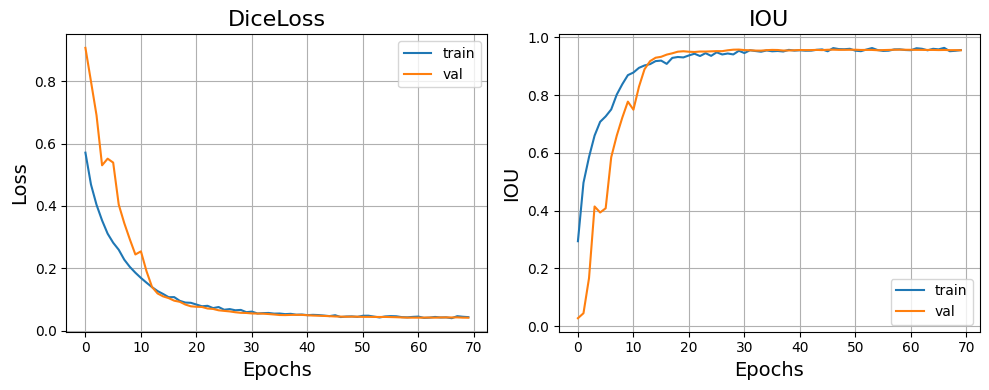

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# График для потерь (loss)
axes[0].plot(loss_logs["train"], label="train")
axes[0].plot(loss_logs["val"], label="val")
axes[0].set_title("DicеLoss", fontsize=16)
axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].grid(True)
axes[0].legend()

# График для метрики (IOU)
axes[1].plot(metric_logs["train"], label="train")
axes[1].plot(metric_logs["val"], label="val")
axes[1].set_title("IOU", fontsize=16)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].set_ylabel("IOU", fontsize=14)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.savefig('Dice_IoU', format='pdf')
plt.show()

# Test best saved model

In [49]:
# load best saved checkpoint
#best_model = torch.load('models/best_model_new.pth')
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [95]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [96]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR,
    Y_TEST_DIR,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, dice_loss - 0.1438, fscore - 0.8885, iou_score - 0.8001]


# Visualize predictions

In [104]:
def _colorize_mask(
    mask: np.ndarray,
    morph_kernel_size: int = 5,
    min_object_area: int = 10,
    apply_processing: bool = True
):
    """
    Преобразует многоканальную маску (C, H, W) в трехканальное изображение (H, W, 3),
    где каждый объект окрашивается в цвет класса, который занимает большую площадь.
    """
    colors_imshow = {
        "background": np.array([0, 0, 0]),
        "white_egg": np.array([0, 255, 0]),
        "brown_egg": np.array([255, 0, 0]),
    }

    colored_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
    object_counts = {cls: 0 for cls in CLASSES if cls != "background"}

    if apply_processing:
        # Логика с объединением масок и морфологическими операциями
        combined_mask = np.zeros((mask.shape[1], mask.shape[2]), dtype=np.uint8)
        for i, singlechannel_mask in enumerate(mask):
            if CLASSES[i] != "background":
                combined_mask = cv2.bitwise_or(combined_mask, singlechannel_mask.astype(np.uint8))

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size)) if morph_kernel_size > 0 else None
        if kernel is not None:
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

        num_labels, labels = cv2.connectedComponents(combined_mask)

        for label in range(1, num_labels):
            obj_mask = (labels == label).astype(np.uint8)
            area = np.sum(obj_mask)
            if area < min_object_area:
                continue

            class_areas = {}
            for i, singlechannel_mask in enumerate(mask):
                cls = CLASSES[i]
                if cls != "background":
                    class_area = np.sum(singlechannel_mask[obj_mask > 0])
                    class_areas[cls] = class_area

            dominant_class = max(class_areas, key=class_areas.get)
            object_counts[dominant_class] += 1
            colored_mask[obj_mask > 0] = colors_imshow[dominant_class]
    else:
        # Исходная логика без обработки (показываем прямое предсказание)
        for i, singlechannel_mask in enumerate(mask):
            cls = CLASSES[i]
            if cls != "background":
                num_labels, labels = cv2.connectedComponents(singlechannel_mask.astype(np.uint8))
                object_counts[cls] = num_labels - 1
                colored_mask += np.multiply.outer(singlechannel_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, object_counts

def reverse_normalize(img: np.ndarray, mean: list, std: list) -> np.ndarray:
    """
    Отменяет нормализацию изображения.

    Параметры:
        img (np.ndarray): Нормализованное изображение в формате (H, W, C)
        mean (list): Средние значения, использованные для нормализации [R, G, B]
        std (list): Стандартные отклонения, использованные для нормализации [R, G, B]

    Возвращает:
        np.ndarray: Обратно нормализованное изображение в диапазоне [0, 1]
    """
    img = img.copy()
    img = img * np.array(std) + np.array(mean)
    return np.clip(img, 0, 1)

def visualize_predicts(
    img: np.ndarray,
    mask_gt: np.ndarray,
    mask_pred: np.ndarray,
    normalized=False,
    morph_kernel_size: int = 5,
    min_object_area: int = 10
):
    """
    Визуализация изображения, GT маски и предсказанной маски (до и после обработки).

    Параметры:
        img (np.ndarray): Изображение формы (C, H, W).
        mask_gt (np.ndarray): GT маска формы (H, W).
        mask_pred (np.ndarray): Предсказанная маска формы (H, W).
        normalized (bool): Флаг, указывающий, нормализовано ли изображение.
        morph_kernel_size (int): Размер ядра для морфологических операций.
        min_object_area (int): Минимальная площадь объекта в пикселях.
    """
    # Преобразование масок в многоканальный формат
    mask_gt = np.stack([(mask_gt == i) for i in range(len(CLASSES))])
    mask_pred = np.stack([(mask_pred == i) for i in range(len(CLASSES))])

    # Инвертируем нормализацию изображения
    img = img.transpose(1, 2, 0)
    if normalized:
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Визуализация GT
    mask_gt_colored, object_counts_gt = _colorize_mask(mask_gt, apply_processing=False)

    # Визуализация предсказаний (до обработки)
    mask_pred_raw_colored, object_counts_pred_raw = _colorize_mask(mask_pred, apply_processing=False)

    # Визуализация предсказаний (после обработки)
    mask_pred_processed_colored, object_counts_pred_processed = _colorize_mask(
        mask_pred,
        morph_kernel_size=morph_kernel_size,
        min_object_area=min_object_area
    )

    axes[0].imshow(img)
    axes[0].set_title("Исходное изображение")
    axes[0].axis('off')

    axes[1].imshow(mask_gt_colored)
    axes[1].set_title(f"\n Исходная маска: \n {format_counts(object_counts_gt)}")
    axes[1].axis('off')

    axes[2].imshow(mask_pred_raw_colored)
    axes[2].set_title(f"\n Предсказанная маска от UNet: \n {format_counts(object_counts_pred_raw)}")
    axes[2].axis('off')

    axes[3].imshow(mask_pred_processed_colored)
    axes[3].set_title(f"\n Морфологическая обработка маски, выданной UNet: \n {format_counts(object_counts_pred_processed)}")
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig('result', format='pdf')
    plt.show()

def format_counts(counts: dict) -> str:
    return " | ".join([f"{cls}: {counts.get(cls, 0)}" for cls in CLASSES if cls != "background"])

(256, 256) (3, 256, 256) (3, 256, 256)


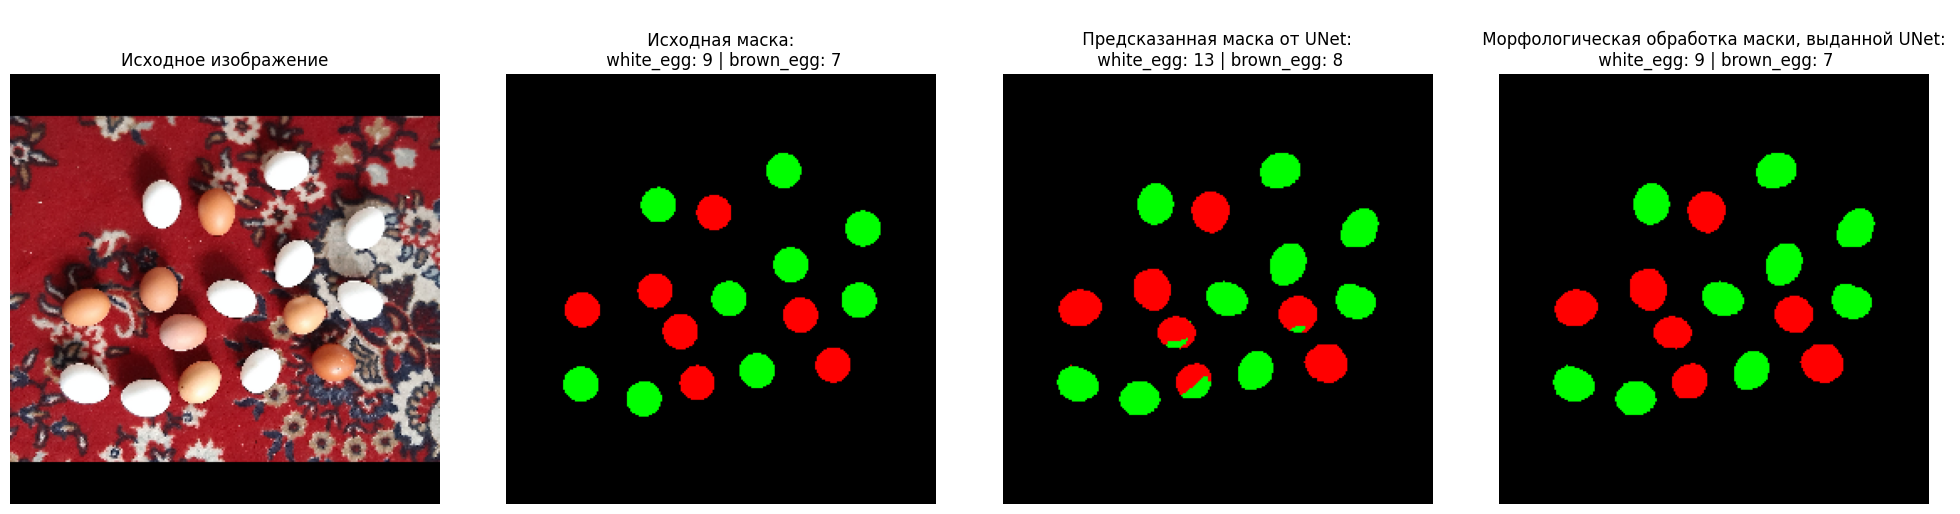

In [119]:
for i in range(1):
    n = np.random.choice(len(test_dataset))

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

---